## Testing trained models on various images:
  * load in saved hats,glasses, and beard models 
  * test each model on the same single image and compare image results 
      * try on all pics, randomly select a one from data/pics
      * try how it works on noncropped images
         * require cropping to better recognize beard, glasses
         * hats require extra tuning (high false positive)
  * add facial cropping:  
      - [facial recognizition software](https://github.com/ageitgey/face_recognition)
         - doesn't work for certain images especially with grainy faces that look down
            - fall back to zoom out images
  * hat model: (resnet50_hat with cropping is 100%)
     - cropping + resnet50_hat : 100% accuracy 
     - cropping + vgg16_hat : better than without cropping but resnet50_hat is the best 
     
  * beard model:(resnet50 does better)
     - cropping + resnet50_beard: better than without cropping but need to fine tune cropping to pick up certain features, can't pick up subtle or zoomed out beard 
     
     - cropping + vgg16_beard: much better but need to improve zoom in to pick up beard 
  
  * glasses model:(vgg16 does better)
     - cropping + resnet50_glasses: high false positive 
     - resnet50 + not cropping: can't pick up sutble glasses 
     
     - cropping + vgg16_glasses: only 1 picture was wrong (zoom in makes a difference)
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0903 23:44:13.278832 140472600590144 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 23:44:13.279775 140472600590144 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [2]:
import face_recognition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from keras.applications.vgg16 import preprocess_input as vg16
from keras.applications.resnet50 import preprocess_input as rs50
import os
from PIL import Image as pil_image

ModuleNotFoundError: No module named 'face_recognition'

In [3]:
def cropping(file_path):
    '''
    file_path: file_path for the image

    return cropped image of face
    '''
    # load image
    image = face_recognition.load_image_file(file_path)
    face_locations = face_recognition.face_locations(image)
    # list of images with tuples, 4 points
    # (ymin,xmax,ymax,xmin)
    faces = []
    for loc in face_locations:
        delta_y = loc[2] - loc[0]
        delta_x = loc[1] - loc[3]
        y_width = 2.5*delta_y  # experimented to find a good width for hats and beard
        x_increase = int((y_width*0.8 - delta_x)/2)
        y_increase = int(1.25*delta_y/2)
        # make sure not to go out of range
        y_min = loc[0]-y_increase
        y_max = loc[2]+y_increase
        x_min = loc[3]-x_increase
        x_max = loc[1]+x_increase
        if x_min < 0:
            x_min = 0
        if x_max > image.shape[1]:
            x_max = image.shape[1]
        if y_min < 0:
            y_min = 0
        if y_max > image.shape[0]:
            y_max = image.shape[0]
        faces.append(image[y_min:y_max,x_min:x_max, :])
    return faces

In [4]:
cropping('/Users/mindy/Desktop/celebrity_images/img24.jpg')
# 7,8,24 found none

[]

---
#### Import pretrained models: 

In [5]:
def load_pretrained_models(model_path,weight_path):
    '''
    inputs:
    model_path: json model path for resnet50 or vgg16
    weight_path: path to saved best weights as h5 
    returns:
    saved models
    '''
    # load json and create model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight 
    loaded_model.load_weights(weight_path)
    return loaded_model

#### Load all three models

In [6]:
model_path_vgg16 = '../tuning_data/VGG_16_tuning/vgg_model.json'
file_path = '../tuning_data/VGG_16_tuning/best_vgg_model_eye'
eye_wear = file_path+'best_vgg_model_eyewears_2.h5'
hat = file_path+'best_vgg_model_hat_2.h5'
beard = file_path+'best_vgg_model_beard_2.h5'
vgg_glasses = load_pretrained_models(model_path_vgg16,eye_wear)
vgg_hat = load_pretrained_models(model_path_vgg16,hat)
vgg_beard = load_pretrained_models(model_path_vgg16,beard)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model_path_resnet = '../tuning_data/resnet_data/resnet50_model_5_up.json'
file_path = '../tuning_data/resnet_data/untracked_resnet50/'
eye_wear = file_path+'best_resnet50_model_eyewear.h5'
hat = file_path+'best_resnet50_model_hat.h5'
beard = file_path+'best_resnet50_model_beard.h5'
resnet_glasses = load_pretrained_models(model_path_resnet,eye_wear)
resnet_hat = load_pretrained_models(model_path_resnet,hat)
resnet_beard = load_pretrained_models(model_path_resnet,beard)

#### WARNINGS: in all three cases, 0 means yes and 1 means no 

### Checking images:

#### convert jpg image into np.array as data input

In [ ]:
def test_image(model,filepath,label, model_type):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    model_type: resnet50 or vgg16 a string
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    for file in files:
        if file != '.DS_Store':
        # get face locations 
            faces = cropping(os.path.join(filepath,file))
            if not faces:
                # image recognitiond doesn't work go to zoom out 
                print(f'no faces in {file}')
                if model_type =='vgg16':
                    img = load_img(os.path.join(filepath,file),target_size=(150,150))
                    img = img_to_array(img)
                    img = img/255
                    plt.imshow(img)
                    plt.show()
                if model_type =='resnet50':
                    img = load_img(os.path.join(filepath,file),target_size=(224,224))
                    img = img_to_array(img)
                    img = rs50(img)
                    plt.imshow(img)
                    plt.show()
                img = np.expand_dims(img,axis=0)
                if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
                    print(f'No {label}')
                else:
                    print(f'YES {label}')
                continue
            for face in faces:
                # remove identified false faces 
                if face.shape[0] <= 200 or face.shape[1] <= 200:
                    continue
                plt.imshow(face)
                plt.show()
                if model_type =='resnet50':
                    img = pil_image.fromarray(face).resize((224,224),pil_image.NEAREST)
                    img = np.expand_dims(img,axis=0)
                    img = rs50(img)
                if model_type =='vgg16':
                    img = pil_image.fromarray(face).resize((150,150),pil_image.NEAREST)
                    img = np.expand_dims(img,axis=0)
                    img = img/255
                if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
                    print(f'No {label}')
                else:
                    print(f'YES {label}')   

In [7]:
def testing_no_cropping(model,filepath,label,model_type):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    model_type: resnet50 or vgg16 a string
    returns:
    print an image plus labels
    '''
    files = os.listdir('/Users/mindy/Desktop/Testing_Images/')
    for file in files:
        if file != '.DS_Store':
            if model_type =='vgg16':
                img = load_img(os.path.join(filepath,file),target_size=(150,150))
                img = img_to_array(img)
                img = img/255
                plt.imshow(img)
                plt.show()
            if model_type =='resnet50':
                img = load_img(os.path.join(filepath,file),target_size=(224,224))
                img = img_to_array(img)
                img = rs50(img)
                plt.imshow(img)
                plt.show()
            img = np.expand_dims(img,axis=0)
            if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
                print(f'No {label}')
            else:
                print(f'YES {label}')

### Testing_without_cropping_software

In [ ]:
# testing_no_cropping(vgg_glasses,'/Users/mindy/Desktop/Testing_Images/','hat','vgg16')

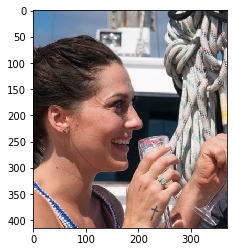

No hat


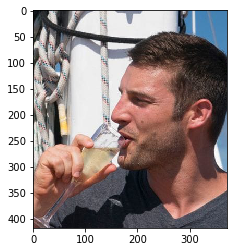

No hat


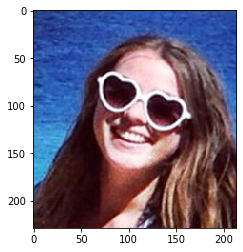

No hat
no faces in img24.jpg


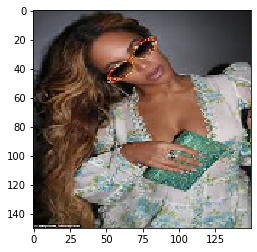

No hat


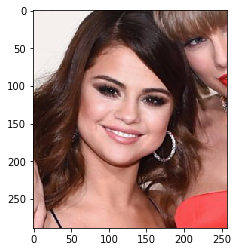

No hat


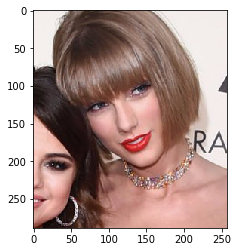

No hat
no faces in img8.jpg


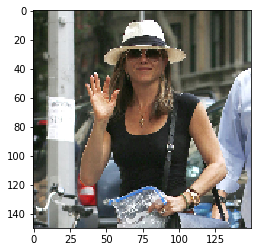

YES hat


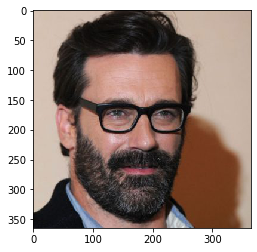

No hat


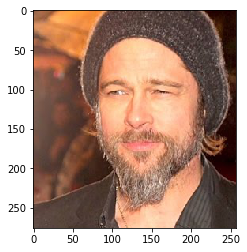

YES hat


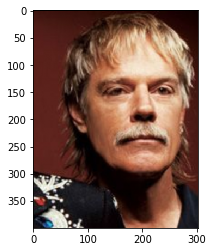

No hat
no faces in img7.jpg


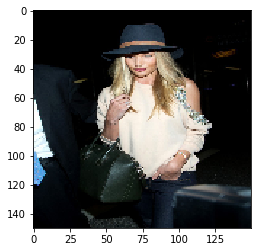

No hat


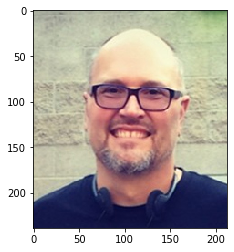

No hat


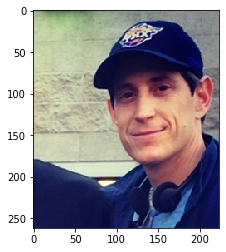

YES hat


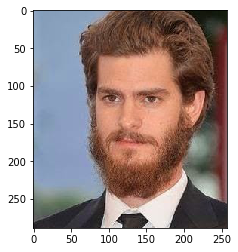

No hat


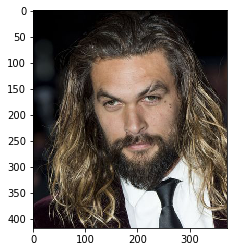

No hat


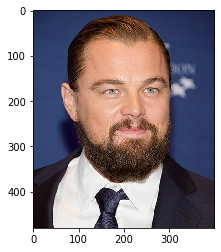

No hat


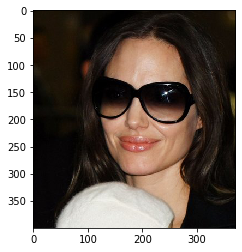

No hat


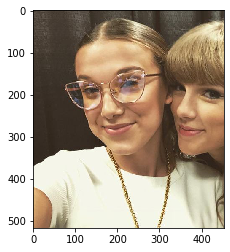

No hat


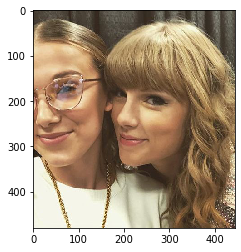

No hat


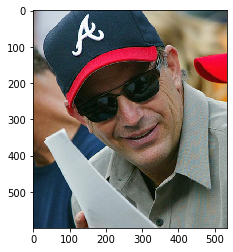

YES hat


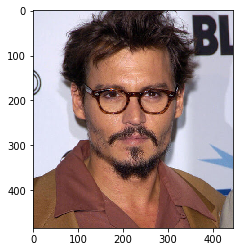

No hat


In [17]:
test_image(vgg_hat,'/Users/mindy/Desktop/celebrity_images/','hat','vgg16')

### Test on cropped images 

In [ ]:
test_image(hat_model_3, '/Users/mindy/Desktop/Testing_Images_Cropped/','hat')

### Test on noncropped images 

In [ ]:
# test_image(glasses_model_2, '/Users/mindy/Desktop/Testing_Images/','glasses')

In [ ]:
# test_image_2(glasses_model, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

# needs thick ridges to pick up glasses, need to separate glasses from sunglasses 

In [ ]:
# test_image_2(glasses_model_3, '/Datastore/GoogleImages/selected/glasses/','eyewear')

In [ ]:
# test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

In [ ]:
# test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/glasses/','eyewear')

### Randomly test on beard model 

In [ ]:
test_image(beard_model, '../data/pics', 'beard')

### Test on noncropped images 

In [ ]:
test_image(beard_model, '../data/zoom_out/','beard')

### Randomly test on hat model 

In [ ]:
test_image(hat_model, '../data/pics', 'hat')

In [ ]:
test_image_2(beard_model_2, '/Datastore/GoogleImages/selected/beard/','beard')

In [ ]:
test_image_2(hat_model, '/Datastore/GoogleImages/selected/hat/','hat')

### Test on noncropped images 

In [ ]:
test_image(hat_model, '../data/zoom_out/','hat')